# Do Batch Processing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

/home/alex/NuMI/PELEE/


In [2]:
# Set False if doing Run 1, True if doing Run 3

isRun3 = True

ending = "Jan19b"

## BNB Sample Histograms - Nue Nue

In [3]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
#full sample
if isRun3 == False:
    NUE  = '/numi_run1_nue_overlay_fhc'+ls.APPEND #newTune
elif isRun3 == True:
    NUE  = '/numi_run3b_nue_overlay_rhc'+ls.APPEND

#actually fetch datasets
nue_nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_nue]

nue_variables = ["run", "sub", "evt", "swtrig_pre", "category",             
             "trk_score_v", "topological_score", "shr_score", "shr_px","shr_py","shr_pz",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi", "npi0",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy', 'nmuon']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz", "proton_e", "elec_e", "mc_E"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_nue  = nue_nue.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)

['nslice', 'category', 'shr_pz', 'shr_tkfit_nhits_U', 'reco_nu_vtx_sce_x', 'slnunhits', 'selected', 'shr_phi', 'npion', 'n_showers', 'shr_tkfit_dedx_U', 'shr_energy_cali', 'shr_py', 'tksh_angle', 'hits_ratio', 'shr_tkfit_nhits_V', 'shr_theta', 'shrmoliereavg', 'shr_tkfit_dedx_Y', 'flash_time', 'n_tracks_contained', 'trk_energy_tot', 'shr_score', 'shr_energy', 'tksh_distance', 'topological_score', 'shr_tkfit_nhits_Y', 'trk_energy', 'reco_nu_vtx_sce_y', 'nu_pdg', 'n_tracks', 'shr_tkfit_dedx_V', 'trk_score_v', 'evt', 'run', 'reco_nu_vtx_sce_z', 'contained_fraction', 'sub', 'n_showers_contained', 'shr_tkfit_npoints', 'nproton', 'shrsubclusters1', 'shrsubclusters2', 'ccnc', 'trkshrhitdist2', 'CosmicIPAll3D', 'swtrig_pre', 'shr_energy_tot_cali', 'shrsubclusters0', 'nmuon', 'slnhits', 'shr_distance', 'npi0', 'shr_px']


In [4]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_nue]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']
    #print(df['mc_pdg'])

In [5]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_nue]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    

In [6]:
#nue_nue = pot_scale(nue_nue, 'intrinsic', ISRUN3)

if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    nue_intrinsic_pot = 2.38181E22
elif isRun3 == True:
    beamon_pot = 5.014E20 #v5
    nue_intrinsic_pot = 2.53486e+22

nue_nue['pot_scale'] = beamon_pot/nue_intrinsic_pot

In [7]:
nue_nue['totweight_data'] = nue_nue['pot_scale']*nue_nue['weightSplineTimesTuneTimesPPFX']

In [8]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [9]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [10]:
#These two are the same

#print(df["elec_vx"])
#print(df["true_nu_vtx_x"])

In [11]:
#TRUTH VARIABLE

import time
s = time.time()

for i,df in enumerate(df_v):
    df["elec_px_asmuon"] = np.nan
    df["elec_py_asmuon"] = np.nan
    df["elec_pz_asmuon"] = np.nan
    for j in range(len(df["mc_pdg"])):
        pdg_vector = df["mc_pdg"].iloc[j][0]
        px_vector = df["mc_px"].iloc[j]
        py_vector = df["mc_py"].iloc[j]
        pz_vector = df["mc_pz"].iloc[j]
        result = np.where(pdg_vector==11)[0]
        if np.size(result):
            df.loc[j, "elec_px_asmuon"] = px_vector[result][0]
            df.loc[j, "elec_py_asmuon"] = py_vector[result][0]
            df.loc[j, "elec_pz_asmuon"] = pz_vector[result][0]
            
    print(df["elec_px_asmuon"])
    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

entry
0         0.826350
1        -0.278695
2        -0.077950
3         0.592236
4         0.073023
            ...   
124423    0.703084
124424         NaN
124425    0.103383
124426    0.200630
124427   -0.089653
Name: elec_px_asmuon, Length: 124428, dtype: float64
time to run:  81.78183770179749


In [12]:
#TRUTH_VARIABLE

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'] + df['elec_pz_asmuon']*df['elec_pz_asmuon'])
    df['targetPt_asmuon']    = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'])
    df['targetTheta_asmuon'] = np.arccos(df['elec_pz_asmuon']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['elec_py_asmuon'],df['elec_px_asmuon'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

In [13]:

s = time.time()

Mp = 0.938272046

for entry in df_v:
    # Each of the things here is a column of arrays
    # First, set everywhere that is 2212 = True and False otherwise
    mask_2 = entry["mc_pdg"].apply(lambda x: np.array(2212 == x))
    # Now find which entries contain a 2212 value
    mask_1 = mask_2.apply(lambda x: np.any(x))
    # Next do the maths to the entries (we'll mask out unwanted bits later)
    mask_3 = entry["mc_E"].apply(lambda x: np.array(x > (0.04 + Mp)))
    # As the contents of mask_2 and mask_3 are arrays, this * operation
    # will multiply every element of mask_2 by every element of mask_3
    # Essentially performing an elementwise AND on every element
    mask_4 = mask_2 * mask_3
    # Default value => 0 where no mask is true
    entry["proton_total_KE"] = np.zeros_like(entry["proton_e"].values)
    # Finally for every place mask_4 applies, we want the mc_E value less Mp summed
    nums = (((entry.loc[:, "mc_E"] - Mp) * mask_4)).apply(lambda x: np.sum(x))
    # And finally, plonk this value into the dataframe
    entry.loc[mask_1, "proton_total_KE"] = nums[mask_1]

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  1.1435303688049316


In [14]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_nue]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  34.88300633430481


In [15]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [16]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
    

In [17]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_nue]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
    df["true_e"] = df["elec_e"] + df["proton_total_KE"]
    #print(df["proton_e"])

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])


In [18]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_nue]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [19]:
# Some quick clean up since some strange events get in there
nue_nue   = nue_nue.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_nue]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

In [20]:
print(isRun3)
print(ending)

True
Jan19b


In [21]:
#Teleporttoherestart

#ending = "Dec19"


df_v = [nue_nue]
for i,df in enumerate(df_v):
    
    df['is_signal'] = np.where( (df.swtrig_pre==1) 
                                 & (df.nu_pdg==12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    
    df.loc[ (df['is_signal']== True), 'category' ] = 1

#SIGNAL SHOULD NOT DEPEND ON VARIABLE


In [22]:
SIGNAL_NUE_SEL_QUERY = 'is_signal==True'

In [23]:
#New categories

for i,df in enumerate(df_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where( (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["numu_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_CC_Npi0']== True), 'category' ] = 3
    df["numu_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['numu_CC_0pi0']== True), 'category' ] = 4
    
    df["numu_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 5
    df["numu_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['numu_NC_Npi0']== True), 'category' ] = 6
    
    df["nuebar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-12) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['nuebar_1eNp']== True), 'category' ] = 7
    df["nue_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1), True, False)
    df.loc[ (df['nue_NC']== True), 'category' ] = 8
    df["nue_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['nue_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["nue_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False) , True, False)
    df.loc[ (df['nue_other']== True), 'category' ] = 10
    df["numu_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==14)) & (df.npi0>=1), True, False)
    df.loc[ (df['numu_Npi0']== True), 'category' ] = 11
    df["numu_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==14)) &  (df.npi0==0), True, False)
    df.loc[ (df['numu_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.numu_CC_Npi0==False)
                             & (df.numu_CC_0pi0==False) & (df.numu_NC_Npi0==False) & (df.numu_NC_0pi0==False)
                             & (df.nuebar_1eNp==False) & (df.nue_NC==False) & (df.nue_CCother==False)
                             & (df.nue_other==False) & (df.numu_Npi0==False) & (df.numu_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [24]:
test = np.nansum(df.query("is_signal==True")['totweight_data'])
print('total signal events = '+ str(test))

total signal events = 861.8230914963742


In [25]:
#This deals with any overflow. Have done all bins, even where overflow shouldn't be possible for comepleteness

#ENERGY
tmp = df["true_e"].copy()
mask = (df["true_e"] > 3)
tmp[mask] = 2.75
df["true_e"] = tmp
print(df["true_e"])
#------
tmp = df["true_e"].copy()
mask = (df["true_e"] < 0)
tmp[mask] = 0.25
df["true_e"] = tmp
print(df["true_e"])

#ANGLE
tmp = df["cosNu_Angle_Numi_Elec_asmuon"].copy()
mask = (df["cosNu_Angle_Numi_Elec_asmuon"] > 1)
tmp[mask] = 0.9
df["cosNu_Angle_Numi_Elec_asmuon"] = tmp
print(df["cosNu_Angle_Numi_Elec_asmuon"])
#------
tmp = df["cosNu_Angle_Numi_Elec_asmuon"].copy()
mask = (df["cosNu_Angle_Numi_Elec_asmuon"] < -1)
tmp[mask] = -0.9
df["cosNu_Angle_Numi_Elec_asmuon"] = tmp
print(df["cosNu_Angle_Numi_Elec_asmuon"])

#LEPTON
tmp = df["targetP_asmuon"].copy()
mask = (df["targetP_asmuon"] > 2)
tmp[mask] = 1.875
df["targetP_asmuon"] = tmp
print(df["targetP_asmuon"])
#------
tmp = df["targetP_asmuon"].copy()
mask = (df["targetP_asmuon"] < 0)
tmp[mask] = 0.125
df["targetP_asmuon"] = tmp
print(df["targetP_asmuon"])

entry
0         1.997144
1         0.879212
2         0.442102
3         0.651565
4         0.384598
            ...   
124423    0.903914
124424    2.011892
124425    0.438018
124426    0.356388
124427    0.169663
Name: true_e, Length: 124428, dtype: float32
entry
0         1.997144
1         0.879212
2         0.442102
3         0.651565
4         0.384598
            ...   
124423    0.903914
124424    2.011892
124425    0.438018
124426    0.356388
124427    0.169663
Name: true_e, Length: 124428, dtype: float32
entry
0         0.927170
1         0.339392
2        -0.696491
3         0.653388
4        -0.569014
            ...   
124423    0.905938
124424         NaN
124425   -0.003848
124426    0.397186
124427   -0.489161
Name: cosNu_Angle_Numi_Elec_asmuon, Length: 124428, dtype: float64
entry
0         0.927170
1         0.339392
2        -0.696491
3         0.653388
4        -0.569014
            ...   
124423    0.905938
124424         NaN
124425   -0.003848
124426    0.397186
12

Set up complete

n_events here =  124428
n_events/2 here =  24885.0

1.0
1
0
124428
{'nue_nue': 0.019780185098979827}
is_signal==True& true_e <= 3 & true_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 nue_nue
--------------------------------------
current sample is:  nue_nue
[0.79544514 1.3008945  3.4238088  ... 1.1130309  0.78173316 0.49483666]
current_total  861.8230914963742
861.823091496374217967968434095382690429687500000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  861.8230914963742
861.823091496374217967968434095382690429687500000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  861.8230914963742
861.823091496374217967968434095382690429687500000000000000000000000000000000000
current_total_split  [861.8230914963742]
current_total_hist  [126.0

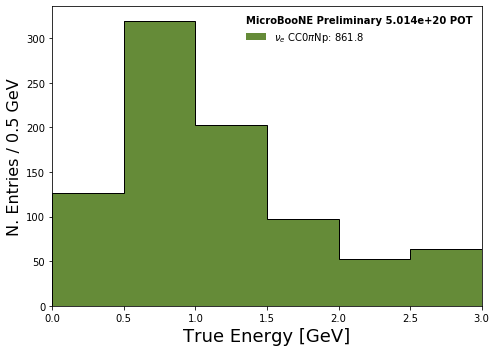

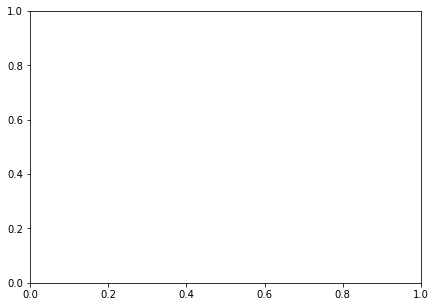

In [38]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("n_events/2 here = ", np.floor(n_events/5))
print("")
batch_size = n_events
#batch_size = int(np.floor(n_events/5))
#n_events = batch_size                     #do this for fist 50

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    start = i*batch_size   #this is i in standard
    print(start)
    #print(end)
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    print(sample_set.shape[0])
    
    samples = {
        #"nue_nue": nue_nue
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 #partial file: 8.885e+19
        nueratio  = pot/2.38181e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.53486e+22

    # NUE
    weights = { #full sample mc = 0.38
                "nue_nue"  : nueratio  * SPLIT * scaling
                #"nue_nue"  : 1
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)


    #Now check on a variable
    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'true_e',6,(0.0, 3.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',8,(0.0, 2.0),"Lepton Momentum (GeV)"
    
    
    #VARIABLE, BINS, RANGE, XTIT = 'elec_e',10,(0.0, 5.0),"Electron Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'proton_e',10,(0.0, 5.0),"Proton Energy [GeV]"

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query = "is_signal==True",
        #query = "",
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",
        #genieweight = "category",
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)
    

No handles with labels found to put in legend.


861.8230914963747
0.0


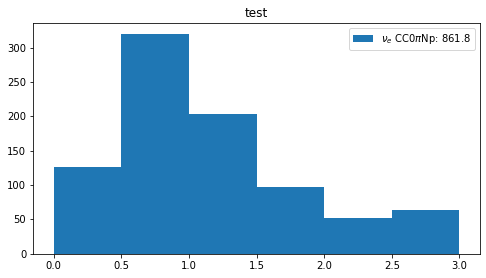

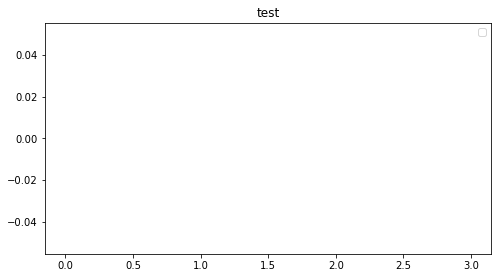

In [39]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
#for i in range(1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    #nue_ax1.set_xlim([0, 5])    #TrueE, lepton mom
    #nue_ax1.set_xlim([-1, 1])    #AngleDiff

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("test")
    plt.legend()

    print(sum(nue_stacked[0]))

In [40]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

126.0597172081872


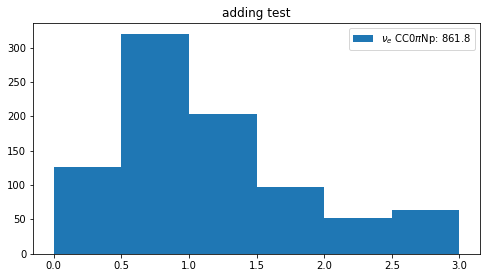

In [41]:
category_labels = {
    1 : r'$\nu_e$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_\mu$ CC $\pi^{0}$',
    4 : r'$\nu_\mu$ CC',
    5 : r'$\nu_\mu$ NC $\pi^{0}$',
    6 : r'$\nu_\mu$ NC',
    7 : r'$\bar{\nu}_e$ CC0$\pi$Np',
    8: r'$\nu_e$ NC',
    9: r'$\nu_e$ CC other',
    10 : r'$\nu_e$ / $\overline{\nu_e}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other',
    0: r'Unknown'
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE, LeptonMom
#nue_ax1.set_xlim([0.0, 5.0])
#nue_ax1.set_ylim([0,150])

#AngleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 180])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

#print('%.75f' % nue_stacked[0][5])
print(nue_stacked[0][0])

In [42]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 0

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [43]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

variable = "Energy"
#variable = "Angle"
#variable = "Lepton"


if isRun3 == False:
    ######full trueE
    if (variable == "Energy"):
        vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_trueE_recoCut_'+ending+'.csv')
        weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    ########angleDiff
    elif (variable == "Angle"):
        vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_true_angleDiff_'+ending+'.csv')
        weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_true_angleDiff_'+ending+'.csv')
    ########leptonMom
    elif (variable == "Lepton"):
        vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_true_leptonMom_'+ending+'.csv')
        weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_true_leptonMom_'+ending+'.csv')
elif isRun3 == True:
    ######full trueE
    if (variable == "Energy"):
        vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
        weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    ########angleDiff
    elif (variable == "Angle"):
        vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
        weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    ########leptonMom
    elif (variable == "Lepton"):
        vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')

### Stat Errors

In [48]:
# sumw2 of the full event rate 
nuwro_full_sumw2 = []


variable = "Energy"
#variable = "Angle"
#variable = "Lepton"


if (variable == "Energy"):
    xvar = "true_e"
    bins = np.arange(0.0, 3.5, 0.5)
elif (variable == "Angle"):
    xvar = "cosNu_Angle_Numi_Elec_asmuon"
    bins = np.arange(-1.0, 1.2, 0.2)
elif (variable == "Lepton"):
    xvar = "targetP_asmuon"
    bins = np.arange(0, 2.25, 0.25)



for i in range(len(bins)-1):

    if i==len(bins)-2: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' <= '+str(bins[i+1])
    else: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' < '+str(bins[i+1])

    #nuwro_full_sumw2.append(sum(datasets_bdt['infv'].query('is_signal==True and '+bin_query).totweight_data ** 2) ) #bug (fixed below)
    nuwro_full_sumw2.append(sum(nue_nue.query(SIGNAL_NUE_SEL_QUERY+ " and " +bin_query).totweight_data ** 2))
    
    
# percent stat error - of the background subtracted event rate 
#print( [(np.sqrt(a)/b) for a,b in zip(nuwro_full_sumw2, nuwro_evt_rate)] )
print(nuwro_full_sumw2)

[6.1183341899647266, 11.71849523331387, 7.86520964610174, 3.337428791122862, 1.7127414560022527, 1.4801928482131381]


In [49]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_trueE_recoCut_"+ending+".csv", 
                   nuwro_full_sumw2,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_true_angleDiff_"+ending+".csv", 
                   nuwro_full_sumw2,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_true_leptonMom_"+ending+".csv", 
                   nuwro_full_sumw2,
                   delimiter =", ", 
                   fmt ='% s')

elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
                   nuwro_full_sumw2,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
                   nuwro_full_sumw2,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("nue_nue_stat_errs_updated_full_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
                   nuwro_full_sumw2,
                   delimiter =", ", 
                   fmt ='% s')

    

### Sys Errors - nue nue

In [90]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 #partial file: 8.885e+19
        nueratio  = pot/2.38181e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.53486e+22

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
                #"nue_nue"  : 1
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'true_e',6,(0.0, 3.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    
    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,
        query= "is_signal==True",
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsPPFX",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX", 
        #genieweight = "category", 
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  124428

1.0
1
{'nue_nue': 0.019780185098979827}
is_signal==True& true_e <= 3 & true_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
        0     1     2     3     4     5     6     7     8     9    ...   590  \
0       508   787   371   616  1339   815   528   298   428    74  ...   297   
1       700   762    70  1187  1389   251   594  1382  1230   863  ...  1719   
2       104  1990  1757  1806   813   573   721  1223  1382   879  ...   153   
3       864  1294   890   967  1054   974  1339  1215  1041   792  ...  1246   
4      1060  1416  1622   922   644  1580   512   549   887  1039  ...  1861   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
40881   924   740   913  1082   669   959  1021  1080   969   887  ...   892   
40882  1913    53   248  1006  1026  1444   200   809   783  3166  ...  1330  

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[126.05971527 319.72634888 202.95361328  96.8460083   52.65753174
  63.57983398]


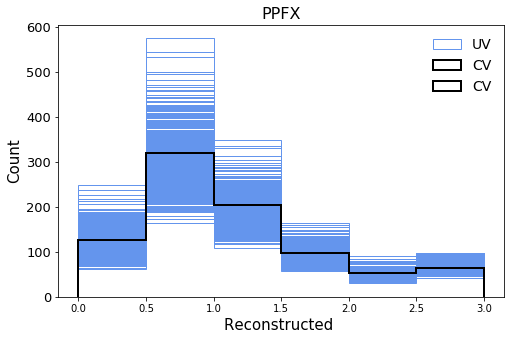

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[0. 0. 0. 0. 0. 0.]


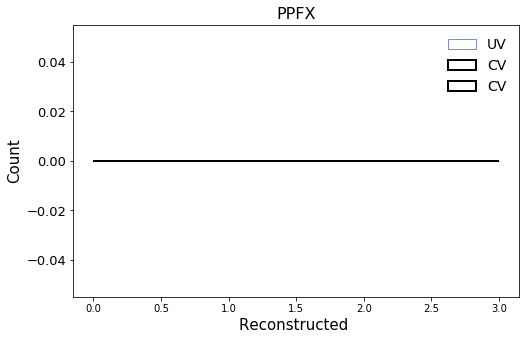

In [91]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    variable = "Energy"
    #variable = "Angle"
    #variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    
    
    print(bin_centers)
    print(bins)
    

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)



    plt.show()

In [92]:
#will need to edit this if batching

nue_nue_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_trueE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    elif (variable == "Lepton"):    
        nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_trueE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_nue_ppfx_detvar_dict.to_csv('nue_nue_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')

In [93]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_nue_ppfx = sum(n_cv_tots)


##################################################################

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [94]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_trueE_recoCut_"+ending+".csv", 
                   final_ns_nue_nue_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_trueE_recoCut_"+ending+".csv", 
                   final_ncvs_nue_nue_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_true_angleDiff_"+ending+".csv", 
                   final_ns_nue_nue_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_true_angleDiff_"+ending+".csv", 
                   final_ncvs_nue_nue_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_true_leptonMom_"+ending+".csv", 
                   final_ns_nue_nue_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_true_leptonMom_"+ending+".csv", 
                   final_ncvs_nue_nue_ppfx,
                   delimiter =", ", 
                   fmt ='% s')
        ###########################################

        total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
        
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
                   final_ns_nue_nue_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_ppfx,
                   delimiter =", ", 
                   fmt ='% s')
        ###########################################

        total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
                   final_ns_nue_nue_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_ppfx,
                   delimiter =", ", 
                   fmt ='% s')
        ###########################################

        total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
                   final_ns_nue_nue_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')


In [95]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 #partial file: 8.885e+19
        nueratio  = pot/2.38181e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.53486e+22

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
                #"nue_nue"  : 1
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'true_e',6,(0.0, 3.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,
        query= "is_signal==True",
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        #genieweight = "category",
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  124428

1.0
1
{'nue_nue': 0.019780185098979827}
is_signal==True& true_e <= 3 & true_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
        0     1     2     3     4     5     6     7     8     9    ...   590  \
0      1430  1090   859  1354  1026  1524  1163  1231  1376  1391  ...  1418   
1      1572  1113   821  1474   961  1750  1181  1309  1506  1521  ...  1539   
2      2543   649   330  2383  1622  1201     1  2015     1     1  ...  2876   
3      1079   368   453  1425  1224   560  1391   469  1533   496  ...  1334   
4      1961   410  1055   745   510  1842  1080   846   884  1061  ...  1727   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
40881  1185  1261  1104  1647  1450  2851  1406  2263  2769  1784  ...   653   
40882  1143  1304   924  1275   383  1488   900  1301  1212  1332  ...   903  

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[126.05971527 319.72634888 202.95361328  96.8460083   52.65753174
  63.57983398]


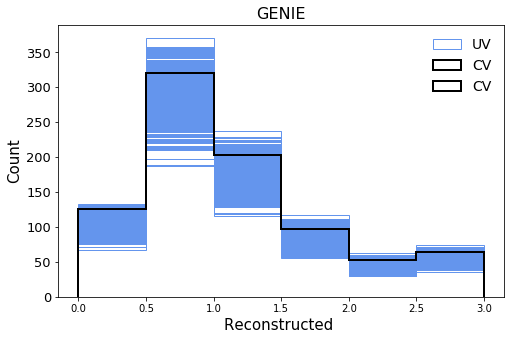

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[0. 0. 0. 0. 0. 0.]


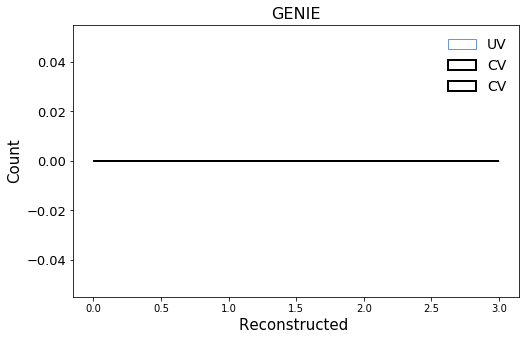

In [96]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    variable = "Energy"
    #variable = "Angle"
    #variable = "Lepton"
    
    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    
    
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('GENIE', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    plt.show()

In [97]:
#will need to edit this if batching

nue_nue_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    if (variable == "Energy"):
        nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_trueE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_trueE_usingSelection_recoCut_run3_'+ending+'.csv') 
    elif (variable == "Angle"):
        nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_nue_genie_detvar_dict.to_csv('nue_nue_syserss_df_genie_detvar_dict_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')

In [98]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_genie.append(sum(masterlist[a]))

final_ncvs_nue_nue_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


In [99]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_trueE_recoCut_"+ending+".csv", 
                   final_ns_nue_nue_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_trueE_recoCut_"+ending+".csv", 
                   final_ncvs_nue_nue_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_true_angleDiff_"+ending+".csv", 
                   final_ns_nue_nue_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_true_angleDiff_"+ending+".csv", 
                   final_ncvs_nue_nue_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_true_leptonMom_"+ending+".csv", 
                   final_ns_nue_nue_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_true_leptonMom_"+ending+".csv", 
                   final_ncvs_nue_nue_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')

elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
                   final_ns_nue_nue_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
                   final_ns_nue_nue_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
                   final_ns_nue_nue_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        

In [100]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("weightsReint")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 #partial file: 8.885e+19
        nueratio  = pot/2.38181e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.53486e+22

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
                #"nue_nue"  : 1
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'true_e',6,(0.0, 3.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,
        query= "is_signal==True",
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsReint",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX", 
        #genieweight = "category",
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  124428
weightsReint
1.0
1
{'nue_nue': 0.019780185098979827}
is_signal==True& true_e <= 3 & true_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
        0     1     2     3     4     5     6     7     8     9    ...   990  \
0       947   818  1192  1001   942   951   864   949  1050   986  ...   853   
1      1033  1058  1049   987  1088   992   904  1010   937  1049  ...   955   
2       964   893  1074  1004   947   978   960   971  1046   978  ...   937   
3       992   976  1015  1000   989   995   991   993  1009   995  ...   986   
4      1187  1692   469   993  1175  1177  1542  1184   798  1043  ...  1608   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
40881   953   867  1071  1007   922   977   977   966  1064   965  ...   940   
40882   975   927  1041  1003   960   987   982   981  1032   983 

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[126.05971527 319.72634888 202.95361328  96.8460083   52.65753174
  63.57983398]


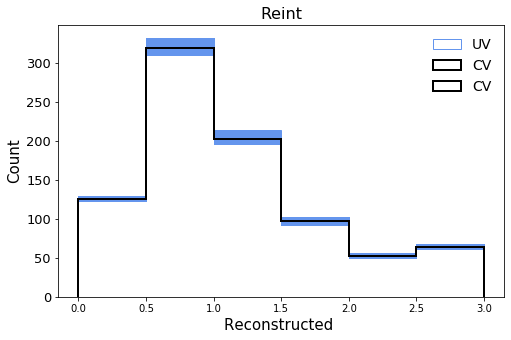

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[0. 0. 0. 0. 0. 0.]


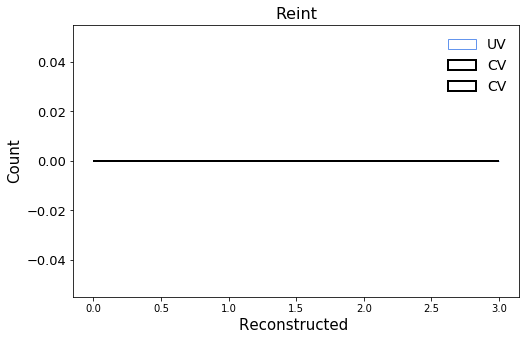

In [101]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    variable = "Energy"
    #variable = "Angle"
    #variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
        
        
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [102]:
#will need to edit this if batching

nue_nue_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    if (variable == "Energy"):
        nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_trueE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_trueE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_nue_reint_detvar_dict.to_csv('nue_nue_syserss_df_reint_detvar_dict_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')

In [103]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_reint.append(sum(masterlist[a]))

final_ncvs_nue_nue_reint = sum(n_cv_tots)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)


In [104]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_trueE_recoCut_"+ending+".csv", 
                   final_ns_nue_nue_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_trueE_recoCut_"+ending+".csv", 
                   final_ncvs_nue_nue_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_true_angleDiff_"+ending+".csv", 
                   final_ns_nue_nue_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_true_angleDiff_"+ending+".csv", 
                   final_ncvs_nue_nue_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_true_leptonMom_"+ending+".csv", 
                   final_ns_nue_nue_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_true_leptonMom_"+ending+".csv", 
                   final_ncvs_nue_nue_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
        
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
                   final_ns_nue_nue_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
                   final_ns_nue_nue_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
                   final_ns_nue_nue_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        

In [105]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        # This is the data POT we normalize to (comes from the data Ntuples)
        pot =  2e+20 #partial file: 8.885e+19
        nueratio  = pot/2.38181e+22 
    elif isRun3 == True:
        pot =  5.014e20
        nueratio  = pot/2.53486e+22

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
                #"nue_nue"  : 1
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'true_e',6,(0.0, 3.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec_asmuon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP_asmuon',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,
        query= "is_signal==True",
        currentsample = "nue_nue",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        #genieweight = "category",
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  124428
1.0
2
{'nue_nue': 0.019780185098979827}
is_signal==True& true_e <= 3 & true_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_nue': 0.019780185098979827}
is_signal==True& true_e <= 3 & true_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------



[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]


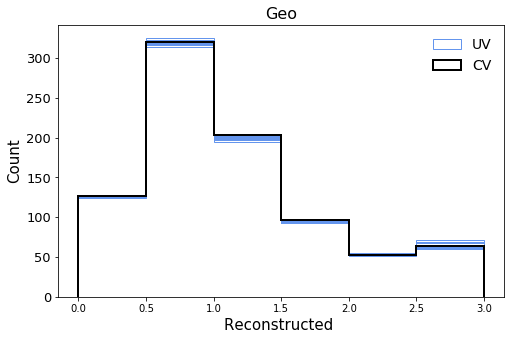

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]


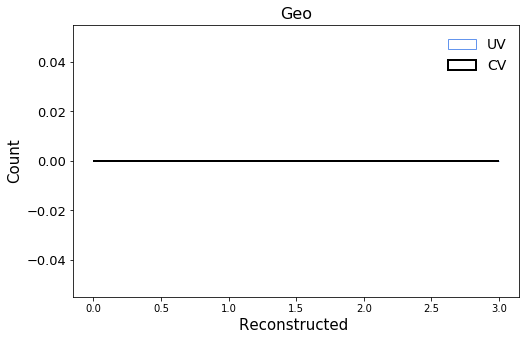

In [106]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    variable = "Energy"
    #variable = "Angle"
    #variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
        
        
    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    #current = (plt.hist(bin_centers, bins, histtype='step', 
    #                 weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    #print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)



    plt.show()

In [107]:
#will need to edit this if batching

nue_nue_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    if (variable == "Energy"):
        nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv') 
    elif (variable == "Angle"):
        nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        nue_nue_geo_detvar_dict.to_csv('nue_nue_syserss_df_geo_detvar_dict_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')

In [108]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_geo.append(sum(masterlist[a]))

final_ncvs_nue_nue_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_nue_nue_geo)):
    final_ns_nue_nue_geo[x] = np.concatenate((final_ns_nue_nue_geo[x][0], final_ns_nue_nue_geo[x][1]))
    
    
#print(final_ns_nue_nue_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [109]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_trueE_recoCut_"+ending+".csv", 
                   final_ns_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_trueE_recoCut_"+ending+".csv", 
                   final_ncvs_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_trueE_recoCut_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_trueE_recoCut_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_true_angleDiff_"+ending+".csv", 
                   final_ns_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_true_angleDiff_"+ending+".csv", 
                   final_ncvs_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_true_angleDiff_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_true_angleDiff_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_true_angleDiff_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_true_leptonMom_"+ending+".csv", 
                   final_ns_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_true_leptonMom_"+ending+".csv", 
                   final_ncvs_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_true_leptonMom_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_true_leptonMom_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_true_leptonMom_'+ending+'.csv')
        
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
                   final_ns_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
                   final_ns_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
                   final_ns_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
                   final_ncvs_nue_nue_geo,
                   delimiter =", ", 
                   fmt ='% s')

        #######################################################

        total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        

## Nue_Mc

Unneeded for truth.

## Nue_Dirt

Unneeded for truth.

## Now for Numu

## Numu_Mc

In [3]:
tree = "NeutrinoSelectionFilter"

#presamp
#NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND
#full
if isRun3 == False:
    NU   = '/numi_run1_nu_overlay_fhc'    +ls.APPEND #newTune
elif isRun3 == True:
    NU   = '/numi_run3b_nu_overlay_rhc'    +ls.APPEND

numu_mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]


uproot_v = [numu_mc] 

#removed reco_e from here
numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc", "swtrig_pre",
        "run","sub","evt",
        "flash_pe", "contained_fraction",
        "trk_llr_pid_score_v", # trk-PID score,"CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nmuon", "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
        "shr_energy_tot_cali", "trk_energy_tot",
        "nproton", "true_e_visible",
        "npi0","npion","pion_e","muon_e",#"pi0truth_elec_etot","slclustfrac""slnunhits", "slnhits",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score", "elec_e", "proton_e", 
        "isVtxInFiducial", "trk_sce_end_x_v", "trk_sce_end_y_v", "trk_sce_end_z_v", "trk_sce_start_x_v",
        "trk_theta", "trk_phi", "trk_energy_muon", "trk_range_muon_mom_v", "trk_mcs_muon_mom_v"
        #"theta", # angle between incoming and outgoing leptons in radians
    ]

numu_varMC = ["nu_e", "true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz", "mc_E","true_nu_px","true_nu_py","true_nu_pz"]
#"true_pt","true_pt_visible","true_nu_px","true_nu_py","true_nu_pz",
#make the list unique
numu_variables = list(set(numu_variables))
print(numu_variables)


    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['muon_e', 'proton_e', '_opfilter_pe_veto', 'evt', 'trk_sce_start_x_v', 'elec_e', '_opfilter_pe_beam', 'nslice', 'tksh_distance', 'trk_energy_muon', 'ccnc', 'npion', 'reco_nu_vtx_sce_y', 'trk_llr_pid_score_v', 'run', 'reco_nu_vtx_sce_x', 'n_showers_contained', 'trk_theta', 'reco_nu_vtx_sce_z', 'nmuon', 'reco_nu_vtx_y', 'trk_sce_end_x_v', 'flash_pe', 'slpdg', 'contained_fraction', 'nproton', 'shr_tkfit_dedx_Y', 'evnunhits', 'pi0_e', 'sub', 'topological_score', 'trk_mcs_muon_mom_v', 'true_e_visible', 'trk_sce_end_y_v', 'trk_energy_tot', 'reco_nu_vtx_z', 'pion_e', 'interaction', 'npi0', 'isVtxInFiducial', 'trk_phi', 'shr_energy_tot_cali', 'category', 'swtrig_pre', 'trk_range_muon_mom_v', 'trk_sce_end_z_v', 'nu_pdg', 'backtracked_pdg', 'reco_nu_vtx_x']


In [4]:
import time
s = time.time()

import pandas as pandas

mc_var   = numu_variables + WEIGHTS + SYSTEMATICS + PPFX + numu_varMC #+ MCFVARS

# This needs modifications (add variables from above)
uproot_v = [numu_mc] 
var_v    = [mc_var] 

print("1")

for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    print("2")
    load_data_run123.process_uproot_numu(CV,CVDF)
    print("3")
    if ii == 0:
        numu_mc = CVDF

s2 = time.time()

print("runtime = ", s2-s)
#Approx 46 mins R1

1
2
trk_llr_pid_v  [[] [] [0.9866963 0.44418675 0.106284544] ... [0.749995 -0.7666651 0.5403374] [-0.8889313 0.63075006 0.036387682] [0.94489354 0.71762836]]
trk_score_v  [[] [] [1.0 0.01982896 0.14982662] ... [0.06810278 0.9277744 0.06486071] [0.96802574 0.06989831 0.096215084] [0.9999674 0.7959594]]


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


updated proton mask test
3
runtime =  1694.2413272857666


In [5]:
df_v = [numu_mc]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [6]:
numu_mc.query('nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1026 and true_nu_vtx_z > 10 and true_nu_vtx_y < 106 and true_nu_vtx_y > -106 and true_nu_vtx_x < \
 246 and true_nu_vtx_x > 10  and nproton > 0 and npion == 0 and npi0==0', inplace=True)# and true_e > 0.04 and true_e < 5 and reco_e > 0.04 and reco_e < 5, inplace=True)

In [7]:
df_v = [numu_mc]
#print(df_v)
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [8]:
s = time.time()

df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    
     # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    
    
s2 = time.time()
print("runtime = ", s2-s)
#Approx 8 mins R1 w/Cut
#Approx 8h for Run3
#Approx 14s for full cut energy
# Approx 11 mins full cut only R1

runtime =  4.266256809234619


In [9]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']

In [10]:
df_v = [numu_mc]
scaleFlat = 0
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ]

In [11]:
if isRun3 == False:
    beamon_pot = 2.0E20 #v5
    overlay_pot =  2.33978E21
elif isRun3 == True:
    beamon_pot = 5.014E20
    overlay_pot =  1.98265e+21    

numu_mc['pot_scale'] = beamon_pot/overlay_pot

In [12]:
numu_mc['totweight_data'] = numu_mc['pot_scale']*numu_mc['weightSplineTimesTuneTimesPPFX']
print(numu_mc['totweight_data'])

entry
4         0.211369
5         0.261992
8         1.365869
10        0.286818
30        0.318307
            ...   
746135    0.256459
746138    0.188489
746144    0.130834
746151    0.320369
746154    0.302231
Name: totweight_data, Length: 69114, dtype: float64


In [13]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [14]:
df_v = [numu_mc]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [15]:
s = time.time()

def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)

s2 = time.time()

print("runtime = ", s2-s)

/tmp/ipykernel_5657/340713361.py:10: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


runtime =  29.88955020904541


In [16]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [17]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [18]:
#TRUE VARIABLE
s = time.time()

for i,df in enumerate(df_v):
    df["muon_px"] = df["ccnc"].copy()
    df["muon_py"] = df["ccnc"].copy()
    df["muon_pz"] = df["ccnc"].copy()
    for j, row in df.iterrows():
        pdg_vector = df["mc_pdg"].loc[j][0]
        px_vector = df["mc_px"].loc[j]
        py_vector = df["mc_py"].loc[j]
        pz_vector = df["mc_pz"].loc[j]
        result = np.where(pdg_vector==13)[0]
        if np.size(result):
            df.loc[j, "muon_px"] = px_vector[result][0]
            df.loc[j, "muon_py"] = py_vector[result][0]
            df.loc[j, "muon_pz"] = pz_vector[result][0]   
            
    #print(df["muon_px"])

print("")    
print("==========================")
s2 = time.time()
print("runetime = ", s2-s)
#R1 approx 22 mins
#R3 approx 10 mins


runetime =  53.94975924491882


In [19]:
#TRUE VARIABLE
#in this we use the NEUTRINO VERTEX and the MUON PHI/THETA and will get the ANGLE BETWEEN THEM

for i,df in enumerate(df_v):
    df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Muon'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta'],x['targetPhi']) , axis=1)
    df['cosNu_Angle_Numi_Muon'] = np.cos(df['nu_Angle_Numi_Muon'])

In [20]:
s = time.time()

Mp = 0.938272046

for entry in df_v:
    # Each of the things here is a column of arrays
    # First, set everywhere that is 2212 = True and False otherwise
    mask_2 = entry["mc_pdg"].apply(lambda x: np.array(2212 == x))
    # Now find which entries contain a 2212 value
    mask_1 = mask_2.apply(lambda x: np.any(x))
    # Next do the maths to the entries (we'll mask out unwanted bits later)
    mask_3 = entry["mc_E"].apply(lambda x: np.array(x > (0.04 + Mp)))
    # As the contents of mask_2 and mask_3 are arrays, this * operation
    # will multiply every element of mask_2 by every element of mask_3
    # Essentially performing an elementwise AND on every element
    mask_4 = mask_2 * mask_3
    # Default value => 0 where no mask is true
    entry["proton_total_KE"] = np.zeros_like(entry["proton_e"].values)
    # Finally for every place mask_4 applies, we want the mc_E value less Mp summed
    nums = (((entry.loc[:, "mc_E"] - Mp) * mask_4)).apply(lambda x: np.sum(x))
    # And finally, plonk this value into the dataframe
    entry.loc[mask_1, "proton_total_KE"] = nums[mask_1]

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  0.7311666011810303


In [21]:
for i,df in enumerate(df_v):
    df["reco_e"] = df["trk_energy_muon"] + df["trk_energy_tot"] + 0.105
    df["true_e"] = df["muon_e"] + df["proton_total_KE"]

In [22]:
numu_mc   = numu_mc.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
df_v = [numu_mc]
for i,df in enumerate(df_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

In [23]:
# for replacing nue CC 
in_AV_query = "-1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8"
nueCC_query = 'abs(nu_pdg)==12 and ccnc==0 and '+in_AV_query

print("# of nueCC in AV in overlay sample = "+str(len(numu_mc.query(nueCC_query))))
len1 = len(numu_mc)

idx = numu_mc.query(nueCC_query).index
numu_mc.drop(idx, inplace=True)
len2 = len(numu_mc) 
print("# of nueCC in AV dropped in overlay = "+str(len1-len2))

# of nueCC in AV in overlay sample = 0
# of nueCC in AV dropped in overlay = 0


In [24]:


dfmc_v = [numu_mc]

for i,df in enumerate(dfmc_v):

    df['is_signal'] = np.where( (df.swtrig_pre==1)
                                 & (df.nu_pdg==14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0)
                                 & (10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)

    df.loc[ (df['is_signal']== True), 'category' ] = 1


In [25]:
#New categories

for i,df in enumerate(df_v):
            
    #df.loc[ (df['is_signal']== True), 'category' ] = 1
    #df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
    #                             & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
    #                             & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["in_fv_query"] = np.where((10 <= df.true_nu_vtx_x) & (df.true_nu_vtx_x <= 246)
                                 & (-106 <= df.true_nu_vtx_y) & (df.true_nu_vtx_y <= 106)
                                 & (10 <= df.true_nu_vtx_z) & (df.true_nu_vtx_z <= 1026), True, False)
    df["out_fv_query"] = np.where( (df.in_fv_query==False), True, False)
    df.loc[ (df['out_fv_query']== True), 'category' ] = 2
    
    df["nue_CC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_CC_Npi0']== True), 'category' ] = 3
    df["nue_CC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==0) & (df.npi0==0), True, False)
    df.loc[ (df['nue_CC_0pi0']== True), 'category' ] = 4
    
    df["nue_NC_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 5
    df["nue_NC_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==12) & (df.ccnc==1) & (df.npi0==0), True, False)
    df.loc[ (df['nue_NC_Npi0']== True), 'category' ] = 6
    
    df["numubar_1eNp"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.nu_pdg==-14) & (df.ccnc==0) & (df.nproton>0) & (df.npion==0) & (df.npi0==0), True, False)
    df.loc[ (df['numubar_1eNp']== True), 'category' ] = 7
    df["numu_NC"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==1), True, False)
    df.loc[ (df['numu_NC']== True), 'category' ] = 8
    df["numu_CCother"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg)==14) & (df.ccnc==0) & (df.is_signal==False) , True, False)
    df.loc[ (df['numu_CCother']== True), 'category' ] = 9
    
    # less specific categories 
    df["numu_other"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (df.is_signal==False)& (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False) , True, False)
    df.loc[ (df['numu_other']== True), 'category' ] = 10
    df["nue_Npi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) &  (abs(df.nu_pdg==12)) & (df.npi0>=1), True, False)
    df.loc[ (df['nue_Npi0']== True), 'category' ] = 11
    df["nue_0pi0"] = np.where((df.swtrig_pre==1)& (df.out_fv_query==False) & (abs(df.nu_pdg==12)) &  (df.npi0==0), True, False)
    df.loc[ (df['nue_0pi0']== True), 'category' ] = 12
    
    df["unknown"] = np.where((df.is_signal==False) & (df.out_fv_query==False) & (df.nue_CC_Npi0==False)
                             & (df.nue_CC_0pi0==False) & (df.nue_NC_Npi0==False) & (df.nue_NC_0pi0==False)
                             & (df.numubar_1eNp==False) & (df.numu_NC==False) & (df.numu_CCother==False)
                             & (df.numu_other==False) & (df.nue_Npi0==False) & (df.nue_0pi0==False), True, False)
    df.loc[ (df['unknown']== True), 'category' ] = 0

In [26]:
SIGNAL_NUMU_SEL_QUERY = 'is_signal==True'

In [27]:
test_signal = np.nansum(numu_mc.query(SIGNAL_NUMU_SEL_QUERY)['totweight_data'])
print('total signal events = '+ str(test_signal))

total signal events = 19199.888995380184


In [28]:
#This deals with any overflow. Have done all bins, even where overflow shouldn't be possible for comepleteness

#ENERGY
tmp = df["true_e"].copy()
mask = (df["true_e"] > 3)
tmp[mask] = 2.75
df["true_e"] = tmp
print(df["true_e"])
#------
tmp = df["true_e"].copy()
mask = (df["true_e"] < 0)
tmp[mask] = 0.25
df["true_e"] = tmp
print(df["true_e"])

#ANGLE
tmp = df["cosNu_Angle_Numi_Muon"].copy()
mask = (df["cosNu_Angle_Numi_Muon"] > 1)
tmp[mask] = 0.9
df["cosNu_Angle_Numi_Muon"] = tmp
print(df["cosNu_Angle_Numi_Muon"])
#------
tmp = df["cosNu_Angle_Numi_Muon"].copy()
mask = (df["cosNu_Angle_Numi_Muon"] < -1)
tmp[mask] = -0.9
df["cosNu_Angle_Numi_Muon"] = tmp
print(df["cosNu_Angle_Numi_Muon"])

#LEPTON
tmp = df["targetP"].copy()
mask = (df["targetP"] > 2)
tmp[mask] = 1.875
df["targetP"] = tmp
print(df["targetP"])
#------
tmp = df["targetP"].copy()
mask = (df["targetP"] < 0)
tmp[mask] = 0.125
df["targetP"] = tmp
print(df["targetP"])


entry
4         2.750000
5         2.472526
8         0.840789
10        1.185649
30        0.849449
            ...   
746135    2.750000
746138    0.661534
746144    0.468508
746151    1.151381
746154    2.750000
Name: true_e, Length: 69114, dtype: float64
entry
4         2.750000
5         2.472526
8         0.840789
10        1.185649
30        0.849449
            ...   
746135    2.750000
746138    0.661534
746144    0.468508
746151    1.151381
746154    2.750000
Name: true_e, Length: 69114, dtype: float64
entry
4         0.997508
5         0.993594
8         0.962881
10        0.823662
30        0.851425
            ...   
746135    0.964353
746138   -0.908435
746144   -0.025118
746151    0.855808
746154    0.860919
Name: cosNu_Angle_Numi_Muon, Length: 69114, dtype: float64
entry
4         0.997508
5         0.993594
8         0.962881
10        0.823662
30        0.851425
            ...   
746135    0.964353
746138   -0.908435
746144   -0.025118
746151    0.855808
746154    0.

Set up complete

n_events here =  69114

1.0
1
{'numu_mc': 0.2528938541850554}
is_signal==True& true_e <= 3 & true_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False 
 numu_mc
--------------------------------------
current_total  19199.88899538018
19199.888995380180858774110674858093261718750000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------
current_total  19199.88899538018
19199.888995380180858774110674858093261718750000000000000000000000000000000000000
---------------------------STILL TOGETHER HERE--------------------------------

current_total  19199.88899538018
19199.888995380180858774110674858093261718750000000000000000000000000000000000000
current_total_split  [19199.88899538018]
current_total_hist  [3476.76043054 6881.00444234 3999.84777793 1805.84827726  956.77725259
 2079.65081472]
19199.88899538016

Returning
0
{'numu_mc': 0.2528938

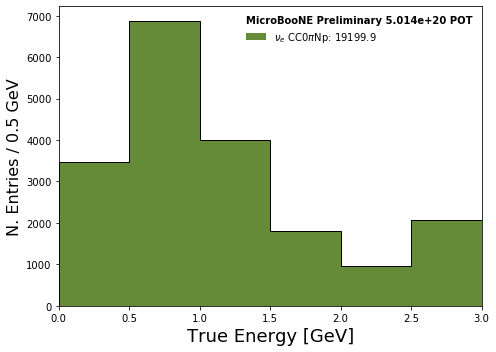

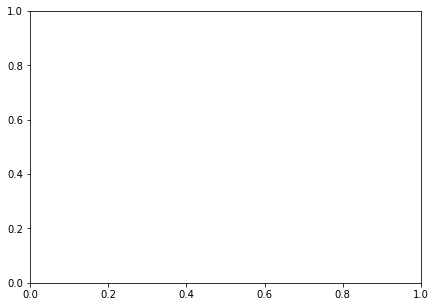

In [41]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        mcratio   = pot/2.33978e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98265e+21

    
    weights = { #full sample mc = 0.38
                "numu_mc": mcratio  * SPLIT * scaling,
                #"numu_mc": 1
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)

    #Now check on a variable
    #Remember to change the plotter keys between truth and mc

    #nue_e to true_e
    VARIABLE, BINS, RANGE, XTIT = 'true_e',6,(0.0, 3.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP',8,(0.0, 2.0),"Lepton Momentum (GeV)"
 
    var, weight, label = my_plotter.plot_variable(
        VARIABLE,
        query= "is_signal==True",
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX", 
        #genieweight = "category", 
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]
    
    print(len(varss))
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


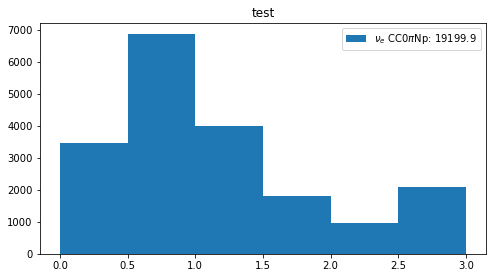

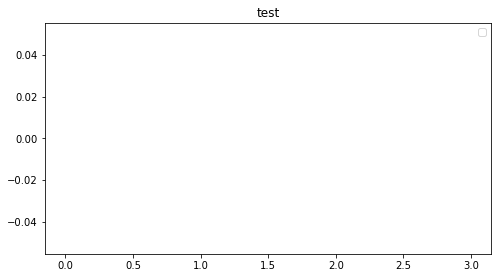

In [42]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    #nue_ax1.set_xlim([0, 5])   #trueE, leptonMom
    #nue_ax1.set_xlim([-1, 1])   #angleMuon

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("test")
    plt.legend()

In [43]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

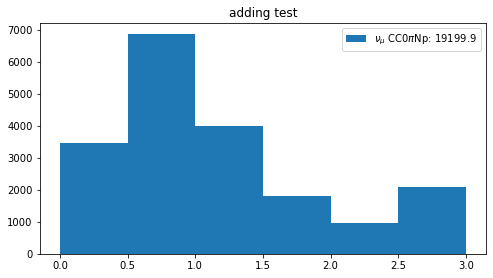

In [44]:
category_labels = {
    1 : r'$\nu_\mu$ CC0$\pi$Np', 
    2 : r'Out FV',
    3 : r'$\nu_e$ CC $\pi^{0}$',
    4 : r'$\nu_e$ CC',
    5 : r'$\nu_e$ NC $\pi^{0}$',
    6 : r'$\nu_e$ NC',
    7 : r'$\bar{\nu}_\mu$ CC0$\pi$Np',
    8: r'$\nu_\mu$ NC',
    9: r'$\nu_\mu$ CC other',
    10 : r'$\nu_\mu$ / $\overline{\nu_\mu}$  other', 
    11 : r'$\nu_\mu$ / $\overline{\nu_e}$  $\pi^{0}$', 
    12 : r'$\nu_\mu$ / $\overline{\nu_e}$  other',
    0: r'Unknown'
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#Nu Energy, leptonMom
#nue_ax1.set_xlim([0, 5])
#nue_ax1.set_ylim([0, 4000])
#angleMuon
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 300])
#angleDiff
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 3600])


nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [45]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

wanted_key = 4

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)


[]

SUMS
[]
[]

Wanted List:
[]



In [46]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

variable = "Energy"
#variable = "Angle"
#variable = "Lepton"

if isRun3 == False:
    #full
    if (variable == "Energy"):
        vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_trueE_recoCut_'+ending+'.csv')
        weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    #angleDiff
    elif (variable == "Angle"):
        vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_true_angleDiff_'+ending+'.csv')
        weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_true_angleDiff_'+ending+'.csv')
    #leptonMom
    elif (variable == "Lepton"):
        vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_true_leptonMom_'+ending+'.csv')
        weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_true_leptonMom_'+ending+'.csv')
elif isRun3 == True: 
    #full
    if (variable == "Energy"):
        vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
        weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    #angleDiff
    elif (variable == "Angle"):
        vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
        weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    #leptonMom
    elif (variable == "Lepton"):
        vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')

### Stat Errors

In [51]:
#numumcstaterrs

# sumw2 of the full event rate 
weight_stat_errs = []

variable = "Energy"
#variable = "Angle"
#variable = "Lepton"

if (variable == "Energy"):
    xvar = "true_e"
    bins = np.arange(0.0, 3.5, 0.5)
elif (variable == "Angle"):
    xvar = "cosNu_Angle_Numi_Muon"
    bins = np.arange(-1.0, 1.2, 0.2)
elif (variable == "Lepton"):
    xvar = "targetP"
    bins = np.arange(0, 2.25, 0.25)

for i in range(len(bins)-1):

    if i==len(bins)-2: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' <= '+str(bins[i+1])
    else: 
        bin_query = xvar+' >= '+str(bins[i])+' and '+xvar+' < '+str(bins[i+1])

    #nuwro_full_sumw2.append(sum(datasets_bdt['infv'].query('is_signal==True and '+bin_query).totweight_data ** 2) ) #bug (fixed below)
    weight_stat_errs.append(sum(numu_mc.query(SIGNAL_NUMU_SEL_QUERY+ " and " +bin_query).totweight_data ** 2))
    
    
# percent stat error - of the background subtracted event rate 
#print( [(np.sqrt(a)/b) for a,b in zip(nuwro_full_sumw2, nuwro_evt_rate)] )
print(weight_stat_errs)

[2727.5072263128795, 3477.660863659001, 1985.723576649105, 756.2977222586176, 365.3099174659089, 631.6588980485235]


In [52]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("numu_mc_stat_errs_updated_full_catsel_nopions_trueE_recoCut_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_stat_errs_updated_full_catsel_nopions_true_angleDiff_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_stat_errs_updated_full_catsel_nopions_true_leptonMom_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("numu_mc_stat_errs_updated_full_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_stat_errs_updated_full_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_stat_errs_updated_full_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
                   weight_stat_errs,
                   delimiter =", ", 
                   fmt ='% s')

    

## Sys errs - numu mc

In [59]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        mcratio   = pot/2.33978e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98265e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling
                #"numu_mc"  : 1
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'true_e',6,(0.0, 3.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,
        query= "is_signal==True",
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsPPFX",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",
        #genieweight = "category",
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  69114

1.0
1
{'numu_mc': 0.2528938541850554}
is_signal==True& true_e <= 3 & true_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
        0     1     2     3     4     5     6     7     8     9    ...   590  \
0      1086  1190   578  1688   850   406   846   798  1680  1036  ...  1163   
1      1112    20   200  1192   976  2227   569   412  1067  1703  ...  1426   
2       995   494   321   492   664   793   929  1770  1082  1258  ...   446   
3      1307   354   432   991   906  1624   759   714   864  1440  ...  1010   
4       945  1028  1141  1011   975  1092  1062  1093  1061   983  ...  1065   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
69018  1818   413   380  1052   870  1081   377   668  1544  1552  ...   250   
69019   807   407   211   384   530   697   771  1478   809   976  ...   439   
6

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[3476.76074219 6881.00488281 3999.84765625 1805.84863281  956.77636719
 2079.65039062]


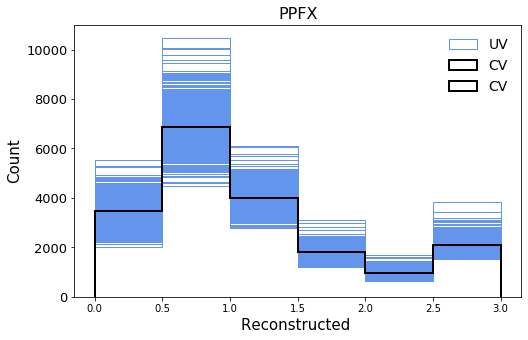

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[0. 0. 0. 0. 0. 0.]


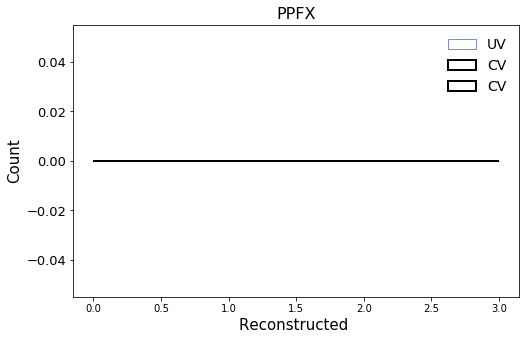

In [60]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    variable = "Energy"
    #variable = "Angle"
    #variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
        print(bin_centers)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    

    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('PPFX', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [61]:
#will need to edit this if batching

numu_mc_ppfx_detvar_dict = pd.DataFrame(detvar_dicts[0])

if isRun3 == False:
    if (variable == "Energy"):
        numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_trueE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_trueE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_mc_ppfx_detvar_dict.to_csv('numu_mc_syserss_df_ppfx_detvar_dict_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')

In [62]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_ppfx.append(sum(masterlist[a]))


final_ncvs_numu_mc_ppfx = sum(n_cv_tots)


#------------------------
frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [63]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_trueE_recoCut_"+ending+".csv", 
                   final_ns_numu_mc_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_trueE_recoCut_"+ending+".csv", 
                   final_ncvs_numu_mc_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_true_angleDiff_"+ending+".csv", 
                   final_ns_numu_mc_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_true_angleDiff_"+ending+".csv", 
                   final_ncvs_numu_mc_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_true_leptonMom_"+ending+".csv", 
                   final_ns_numu_mc_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_true_leptonMom_"+ending+".csv", 
                   final_ncvs_numu_mc_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
        
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
                   final_ns_numu_mc_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
                   final_ns_numu_mc_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
                   final_ns_numu_mc_ppfx[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_ppfx,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')


In [64]:
#############################
##### weightsgenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        mcratio   = pot/2.33978e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98265e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
              #"numu_mc"  : 1
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'true_e',6,(0.0, 3.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,
        query= "is_signal==True",
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",
        #genieweight = "category",
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  69114

1.0
1
{'numu_mc': 0.2528938541850554}
is_signal==True& true_e <= 3 & true_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
        0     1     2     3     4     5     6     7     8     9    ...   590  \
0      1051   608   811   787   676   469   703   358  1359   159  ...   602   
1      1286  1290  1062  1333   791  1443  1131  1325  1311  1358  ...  1171   
2         1  1168     1  2281  2213     1     1     1     1     1  ...  2660   
3      1321  1085   883  1276  1008  1393  1130  1194  1290  1300  ...  1305   
4      1088   424   497  1511   996   612  1367   521  1578   534  ...  1251   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
69018  1398  1868  1912   573   863   716   621   543   986   414  ...   515   
69019   462   609   528   702   292  1202   482   876  1170   609  ...   257   
6

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[3476.76074219 6881.00488281 3999.84765625 1805.84863281  956.77636719
 2079.65039062]


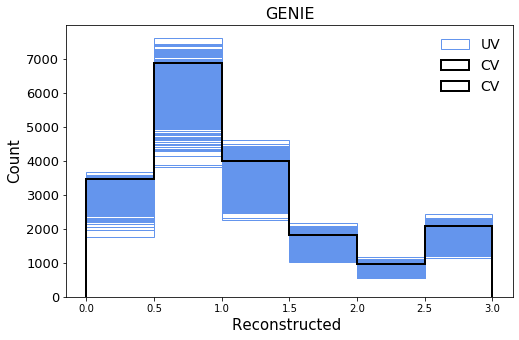

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[0. 0. 0. 0. 0. 0.]


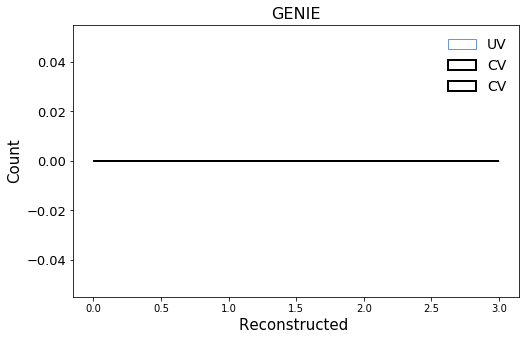

In [65]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    variable = "Energy"
    #variable = "Angle"
    #variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    

    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('GENIE', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    plt.show()

In [66]:
#will need to edit this if batching

numu_mc_genie_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    if (variable == "Energy"):
        numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_trueE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_trueE_usingSelection_recoCut_run3_'+ending+'.csv') 
    elif (variable == "Angle"):
        numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_mc_genie_detvar_dict.to_csv('numu_mc_syserss_df_genie_detvar_dict_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')

In [67]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_genie.append(sum(masterlist[a]))

final_ncvs_numu_mc_genie = sum(n_cv_tots)

##################################################

frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


In [68]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_trueE_recoCut_"+ending+".csv", 
                   final_ns_numu_mc_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_trueE_recoCut_"+ending+".csv", 
                   final_ncvs_numu_mc_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_true_angleDiff_"+ending+".csv", 
                   final_ns_numu_mc_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_true_angleDiff_"+ending+".csv", 
                   final_ncvs_numu_mc_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_true_leptonMom_"+ending+".csv", 
                   final_ns_numu_mc_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_true_leptonMom_"+ending+".csv", 
                   final_ncvs_numu_mc_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
        
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
                   final_ns_numu_mc_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
                   final_ns_numu_mc_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
                   final_ns_numu_mc_genie[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_genie,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')


In [69]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        mcratio   = pot/2.33978e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98265e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
               #"numu_mc"  : 1
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'true_e',6,(0.0, 3.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline, detvar_dict = my_plotter.plot_variable(
        VARIABLE,
        query= "is_signal==True",
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsReint",
        category_query = " ",
        Nuniverse=500,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",
        #genieweight = "category",
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  69114

1.0
1
{'numu_mc': 0.2528938541850554}
is_signal==True& true_e <= 3 & true_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

standard sys err
Universes 500
        0     1     2     3     4     5     6     7     8     9    ...   990  \
0       995   941  1132   992  1031   969   866   980   983  1027  ...   892   
1       990   971  1019  1001   986   994   988   992  1011   994  ...   982   
2       983   949  1034  1001   976   989   980   986  1020   990  ...   970   
3      1078  1263   694   998  1065  1080  1237  1080   905  1014  ...  1253   
4       991   974  1017  1000   988   994   990   993  1010   995  ...   985   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   ...   
69018   970   912  1057  1003   956   982   970   977  1038   982  ...   951   
69019   985   920  1118   995  1003   971   888   977   998  1012  ...   902   
6

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[3476.76074219 6881.00488281 3999.84765625 1805.84863281  956.77636719
 2079.65039062]


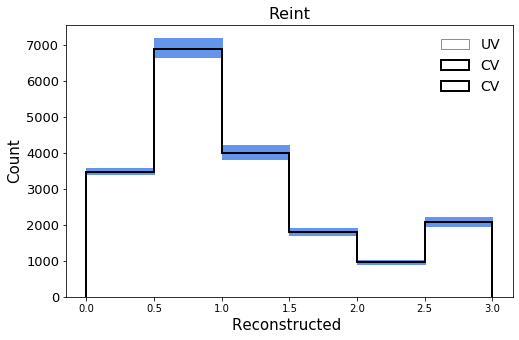

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]
[0. 0. 0. 0. 0. 0.]


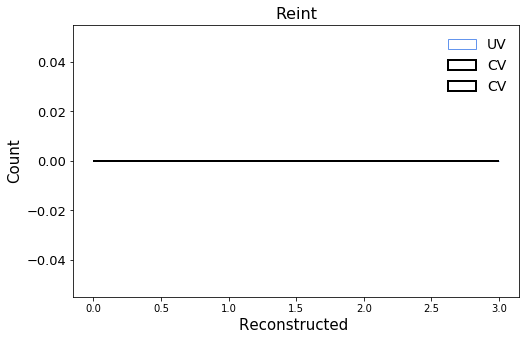

In [70]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    variable = "Energy"
    #variable = "Angle"
    #variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    

    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    current = (plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    print(current)

    plt.title('Reint', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [71]:
#will need to edit this if batching

numu_mc_reint_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    if (variable == "Energy"):
        numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_trueE_usingSelection_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_trueE_usingSelection_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_mc_reint_detvar_dict.to_csv('numu_mc_syserss_df_reint_detvar_dict_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')

In [72]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_reint.append(sum(masterlist[a]))

final_ncvs_numu_mc_reint = sum(n_cv_tots)

###################################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
    
    
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)

In [73]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_trueE_recoCut_"+ending+".csv", 
                   final_ns_numu_mc_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_trueE_recoCut_"+ending+".csv", 
                   final_ncvs_numu_mc_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_true_angleDiff_"+ending+".csv", 
                   final_ns_numu_mc_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_true_angleDiff_"+ending+".csv", 
                   final_ncvs_numu_mc_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_true_leptonMom_"+ending+".csv", 
                   final_ns_numu_mc_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_true_leptonMom_"+ending+".csv", 
                   final_ncvs_numu_mc_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
        
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
                   final_ns_numu_mc_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
                   final_ns_numu_mc_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
                   final_ns_numu_mc_reint[0],
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_reint,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')


In [74]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []
detvar_dicts = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    if isRun3 == False:
        pot =  2e+20 #partial file: 8.885e+19
        mcratio   = pot/2.33978e+21
    elif isRun3 == True:
        pot =  5.014e20
        mcratio  = pot/1.98265e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'true_e',6,(0.0, 3.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Muon',10,(-1.0, 1.0),"cos(Angle Diff)"
    #VARIABLE, BINS, RANGE, XTIT = 'targetP',8,(0.0, 2.0),"Lepton Momentum (GeV)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline, detvar_dict  = my_plotter.plot_variable(
        VARIABLE,
        query= "is_signal",
        currentsample = "numu_mc",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        category_query = " ",
        Nuniverse=10,
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:6]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)
    detvar_dicts.append(detvar_dict)

n_events here =  69114
1.0
2
{'numu_mc': 0.2528938541850554}
is_signal& true_e <= 3 & true_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'numu_mc': 0.2528938541850554}
is_signal& true_e <= 3 & true_e >= 0 
 ~(abs(nu_pdg)==12 and ccnc==0 and -1.55<=true_nu_vtx_x<=254.8 and -116.5<=true_nu_vtx_y<=116.5 and 0<=true_nu_vtx_z<=1036.8) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------



[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]


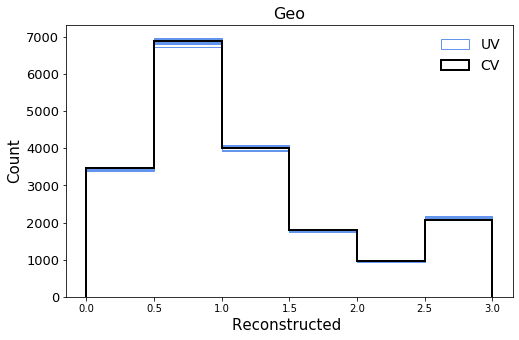

[0.25 0.75 1.25 1.75 2.25 2.75]
[0.  0.5 1.  1.5 2.  2.5 3. ]


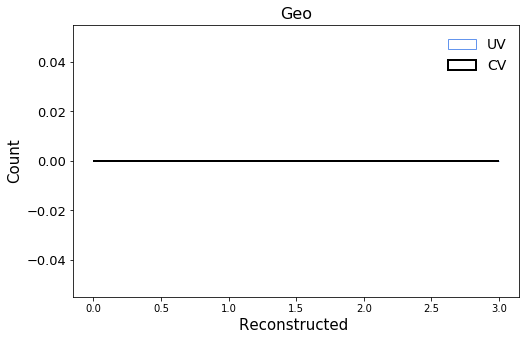

In [75]:
import matplotlib.pyplot as plt
import matplotlib


for j in range(len(detvar_dicts)):

    n=0
    
    variable = "Energy"
    #variable = "Angle"
    #variable = "Lepton"

    if (variable == "Energy"):
        bin_centers = np.arange(0.25, 3.25, 0.5) #energy
        bins = np.arange(0.0, 3.5, 0.5)
    elif (variable == "Angle"):
        bin_centers = np.arange(-0.9, 1.1, 0.2) #Angle
        bins = np.arange(-1, 1.2, 0.2)
    elif (variable == "Lepton"):    
        bin_centers = np.arange(0.125, 2.125, 0.25) #lepton
        bins = np.arange(0, 2.25, 0.25)
    

    print(bin_centers)
    print(bins)

    fig = plt.figure(figsize=(8, 5)) 


    for variation in detvar_dicts[j].keys(): 

        if n==0: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation], 
                 linewidth=1, color='cornflowerblue', label='UV')

        else: 
            plt.hist(bin_centers, bins, histtype='step', weights=detvar_dicts[j][variation],
                 linewidth=1, color='cornflowerblue')

        n+=1   


    plt.hist(bin_centers, bins, histtype='step', 
                     weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)

    #current = (plt.hist(bin_centers, bins, histtype='step', 
    #                 weights=detvar_dicts[j]['CV'], color='black', label='CV', linewidth=2)[0])

    #print(current)

    plt.title('Geo', fontsize=16)

    plt.ylabel('Count' , fontsize=15) # 2.68294E22
    plt.xlabel("Reconstructed ", fontsize=15)

    #plt.xticks(x_ticks, fontsize=13)
    plt.yticks(fontsize=13)

    plt.legend(frameon=False, fontsize=14)

    #plt.xlim(xlow, xhigh)


    plt.show()

In [76]:
#will need to edit this if batching

numu_mc_geo_detvar_dict = pd.DataFrame(detvar_dicts[0])
#print(nue_nue_ppfx_detvar_dict)

if isRun3 == False:
    if (variable == "Energy"):
        numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_true_angleDiff_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_true_leptonMom_'+ending+'.csv')
elif isRun3 == True:
    if (variable == "Energy"):
        numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        numu_mc_geo_detvar_dict.to_csv('numu_mc_syserss_df_geo_detvar_dict_full_500_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')

In [77]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_mc_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_geo.append(sum(masterlist[a]))

final_ncvs_numu_mc_geo = sum(n_cv_tots)
    
for x in range(len(final_ns_numu_mc_geo)):
    final_ns_numu_mc_geo[x] = np.concatenate((final_ns_numu_mc_geo[x][0], final_ns_numu_mc_geo[x][1]))
    
#############################################################
frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [78]:
if isRun3 == False:
    if (variable == "Energy"):
        np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_trueE_recoCut_"+ending+".csv", 
                   final_ns_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_trueE_recoCut_"+ending+".csv", 
                   final_ncvs_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_trueE_recoCut_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_trueE_recoCut_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_trueE_recoCut_'+ending+'.csv')
    elif (variable == "Angle"):

        np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_true_angleDiff_"+ending+".csv", 
                   final_ns_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_true_angleDiff_"+ending+".csv", 
                   final_ncvs_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_true_angleDiff_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_true_angleDiff_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_true_angleDiff_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_true_leptonMom_"+ending+".csv", 
                   final_ns_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_true_leptonMom_"+ending+".csv", 
                   final_ncvs_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_true_leptonMom_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_true_leptonMom_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_true_leptonMom_'+ending+'.csv')
        
elif isRun3 == True:
    if (variable == "Energy"):
        np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
                   final_ns_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_trueE_recoCut_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_trueE_recoCut_run3_'+ending+'.csv')
    elif (variable == "Angle"):
        np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
                   final_ns_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_true_angleDiff_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_true_angleDiff_run3_'+ending+'.csv')
    elif (variable == "Lepton"):
        np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
                   final_ns_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_true_leptonMom_run3_"+ending+".csv", 
                   final_ncvs_numu_mc_geo,
                   delimiter =", ", 
                   fmt ='% s')

        ###########################################

        total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')
        total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_true_leptonMom_run3_'+ending+'.csv')


## Numu_Dirt

Unneeded for truth.